# `causalml` - Meta-Learner Example Notebook
This notebook only contains regression examples.

In [1]:
# pick the right base path (only run ONCE)
import os
base_path = os.path.abspath("../")
os.chdir(base_path)

In [2]:
%reload_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
import warnings

# from causalml.inference.meta import XGBTLearner, MLPTLearner
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.meta import LRSRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# imports from package
import logging
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from copy import deepcopy

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

%matplotlib inline

# Single Treatment Case

### Generate synthetic data

In [143]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array(['treatment_a' if val==1 else 'control' for val in treatment])

## S-Learner

### ATE

In [144]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9696
INFO:causalml:    RMSE (Treatment):     1.0012
INFO:causalml:   sMAPE   (Control):     0.8080
INFO:causalml:   sMAPE (Treatment):     0.4906
INFO:causalml:    Gini   (Control):     0.4434
INFO:causalml:    Gini (Treatment):     0.4842


In [145]:
ate_s

array([0.58243901])

In [146]:
learner_s._classes

{'treatment_a': 0}

### ATE w/ Confidence Intervals

In [147]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9696
INFO:causalml:    RMSE (Treatment):     1.0012
INFO:causalml:   sMAPE   (Control):     0.8080
INFO:causalml:   sMAPE (Treatment):     0.4906
INFO:causalml:    Gini   (Control):     0.4434
INFO:causalml:    Gini (Treatment):     0.4842
INFO:causalml:11/100 bootstraps completed. (5s lapsed)
INFO:causalml:21/100 bootstraps completed. (10s lapsed)
INFO:causalml:31/100 bootstraps completed. (15s lapsed)
INFO:causalml:41/100 bootstraps completed. (20s lapsed)
INFO:causalml:51/100 bootstraps completed. (25s lapsed)
INFO:causalml:61/100 bootstraps completed. (29s lapsed)
INFO:causalml:71/100 bootstraps completed. (34s lapsed)
INFO:causalml:81/100 bootstraps completed. (39s lapsed)
INFO:causalml:91/100 bootstraps completed. (44s lapsed)


In [148]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.3341164 ],
       [0.58243901],
       [0.79249563]])

### CATE

In [149]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9696
INFO:causalml:    RMSE (Treatment):     1.0012
INFO:causalml:   sMAPE   (Control):     0.8080
INFO:causalml:   sMAPE (Treatment):     0.4906
INFO:causalml:    Gini   (Control):     0.4434
INFO:causalml:    Gini (Treatment):     0.4842


In [150]:
cate_s

array([[ 0.57649434],
       [ 0.7564044 ],
       [ 0.62812066],
       ...,
       [-0.11862552],
       [ 0.81248152],
       [ 0.2109772 ]])

### CATE w/ Confidence Intervals

In [151]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9696
INFO:causalml:    RMSE (Treatment):     1.0012
INFO:causalml:   sMAPE   (Control):     0.8080
INFO:causalml:   sMAPE (Treatment):     0.4906
INFO:causalml:    Gini   (Control):     0.4434
INFO:causalml:    Gini (Treatment):     0.4842
INFO:causalml:11/100 bootstraps completed. (5s lapsed)
INFO:causalml:21/100 bootstraps completed. (10s lapsed)
INFO:causalml:31/100 bootstraps completed. (15s lapsed)
INFO:causalml:41/100 bootstraps completed. (20s lapsed)
INFO:causalml:51/100 bootstraps completed. (25s lapsed)
INFO:causalml:61/100 bootstraps completed. (30s lapsed)
INFO:causalml:71/100 bootstraps completed. (35s lapsed)
INFO:causalml:81/100 bootstraps completed. (40s lapsed)
INFO:causalml:91/100 bootstraps completed. (45s lapsed)


In [152]:
cate_s

array([[ 0.57649434],
       [ 0.7564044 ],
       [ 0.62812066],
       ...,
       [-0.11862552],
       [ 0.81248152],
       [ 0.2109772 ]])

In [153]:
cate_s_lb

array([[ 0.35254421],
       [ 0.44082367],
       [ 0.26265205],
       ...,
       [-0.34533793],
       [ 0.59085685],
       [-0.03506206]])

In [154]:
cate_s_ub

array([[0.81533467],
       [1.00261409],
       [0.9085232 ],
       ...,
       [0.39154115],
       [1.0622952 ],
       [0.52280898]])

## T-Learner

### ATE w/ Confidence Intervals

In [229]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9480
INFO:causalml:    RMSE (Treatment):     0.9641
INFO:causalml:   sMAPE   (Control):     0.7965
INFO:causalml:   sMAPE (Treatment):     0.4797
INFO:causalml:    Gini   (Control):     0.4889
INFO:causalml:    Gini (Treatment):     0.5377


In [230]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.55627672],
       [0.59448189],
       [0.63268706]])

### CATE

In [231]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9480
INFO:causalml:    RMSE (Treatment):     0.9641
INFO:causalml:   sMAPE   (Control):     0.7965
INFO:causalml:   sMAPE (Treatment):     0.4797
INFO:causalml:    Gini   (Control):     0.4889
INFO:causalml:    Gini (Treatment):     0.5377


In [232]:
cate_t

array([[ 0.51766217],
       [ 1.28059947],
       [ 0.1578033 ],
       ...,
       [-0.23451126],
       [ 0.97774696],
       [ 0.198053  ]])

### CATE w/ Confidence Intervals

In [233]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9480
INFO:causalml:    RMSE (Treatment):     0.9641
INFO:causalml:   sMAPE   (Control):     0.7965
INFO:causalml:   sMAPE (Treatment):     0.4797
INFO:causalml:    Gini   (Control):     0.4889
INFO:causalml:    Gini (Treatment):     0.5377
INFO:causalml:10/100 bootstraps completed. (5s lapsed)
INFO:causalml:20/100 bootstraps completed. (10s lapsed)
INFO:causalml:30/100 bootstraps completed. (14s lapsed)
INFO:causalml:40/100 bootstraps completed. (19s lapsed)
INFO:causalml:50/100 bootstraps completed. (23s lapsed)
INFO:causalml:60/100 bootstraps completed. (28s lapsed)
INFO:causalml:70/100 bootstraps completed. (32s lapsed)
INFO:causalml:80/100 bootstraps completed. (37s lapsed)
INFO:causalml:90/100 bootstraps completed. (41s lapsed)


In [234]:
cate_t

array([[ 0.51766217],
       [ 1.28059947],
       [ 0.1578033 ],
       ...,
       [-0.23451126],
       [ 0.97774696],
       [ 0.198053  ]])

In [235]:
cate_t_lb

array([[ 0.06587222],
       [ 0.60462681],
       [-0.10897484],
       ...,
       [-1.18727271],
       [ 0.50621215],
       [-0.4558233 ]])

In [236]:
cate_t_ub

array([[0.98554701],
       [1.74615895],
       [1.24846366],
       ...,
       [0.669078  ],
       [1.28537154],
       [0.98453737]])

## X-Learner

### ATE w/ Confidence Intervals

In [243]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9480
INFO:causalml:    RMSE (Treatment):     0.9641
INFO:causalml:   sMAPE   (Control):     0.7965
INFO:causalml:   sMAPE (Treatment):     0.4797
INFO:causalml:    Gini   (Control):     0.4889
INFO:causalml:    Gini (Treatment):     0.5377


In [244]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.50389773],
       [0.54179776],
       [0.57969779]])

### CATE

### CATE w/ Confidence Intervals

In [246]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9480
INFO:causalml:    RMSE (Treatment):     0.9641
INFO:causalml:   sMAPE   (Control):     0.7965
INFO:causalml:   sMAPE (Treatment):     0.4797
INFO:causalml:    Gini   (Control):     0.4889
INFO:causalml:    Gini (Treatment):     0.5377
INFO:causalml:10/100 bootstraps completed. (6s lapsed)
INFO:causalml:20/100 bootstraps completed. (12s lapsed)
INFO:causalml:30/100 bootstraps completed. (18s lapsed)
INFO:causalml:40/100 bootstraps completed. (24s lapsed)
INFO:causalml:50/100 bootstraps completed. (29s lapsed)
INFO:causalml:60/100 bootstraps completed. (35s lapsed)
INFO:causalml:70/100 bootstraps completed. (41s lapsed)
INFO:causalml:80/100 bootstraps completed. (46s lapsed)
INFO:causalml:90/100 bootstraps completed. (52s lapsed)


In [247]:
cate_x

array([[ 0.50365067],
       [ 0.8769697 ],
       [ 0.54220575],
       ...,
       [-0.180242  ],
       [ 0.9180752 ],
       [ 0.22089118]])

In [248]:
cate_x_lb

array([[ 0.22216705],
       [ 0.47742233],
       [-0.29914799],
       ...,
       [-1.04059524],
       [ 0.60149392],
       [-0.17479771]])

In [249]:
cate_x_ub

array([[0.99334868],
       [1.5561669 ],
       [1.29536709],
       ...,
       [0.65455844],
       [1.42401723],
       [0.95252066]])

## R-Learner

### ATE w/ Confidence Intervals

In [194]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [195]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.50381984],
       [0.50423587],
       [0.50465189]])

### CATE

In [171]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [172]:
cate_r

array([[ 0.4129059 ],
       [ 0.9046396 ],
       [ 0.81613529],
       ...,
       [-0.0288884 ],
       [ 0.63902354],
       [ 0.07853517]])

### CATE w/ Confidence Intervals

In [173]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:10/100 bootstraps completed. (5s lapsed)
INFO:causalml:20/100 bootstraps completed. (10s lapsed)
INFO:causalml:30/100 bootstraps completed. (15s lapsed)
INFO:causalml:40/100 bootstraps completed. (19s lapsed)
INFO:causalml:50/100 bootstraps completed. (24s lapsed)
INFO:causalml:60/100 bootstraps completed. (29s lapsed)
INFO:causalml:70/100 bootstraps completed. (34s lapsed)
INFO:causalml:80/100 bootstraps completed. (39s lapsed)
INFO:causalml:90/100 bootstraps completed. (44s lapsed)


In [174]:
cate_r

array([[ 0.39102826],
       [ 0.93643117],
       [ 0.78970027],
       ...,
       [-0.27766651],
       [ 0.68156344],
       [ 0.36618736]])

In [175]:
cate_r_lb

array([[-0.42608047],
       [-0.10831821],
       [-0.67443022],
       ...,
       [-1.53540977],
       [-0.05454972],
       [-0.5361454 ]])

In [176]:
cate_r_ub

array([[1.36585561],
       [2.78943411],
       [2.37734264],
       ...,
       [1.07409953],
       [1.87056649],
       [1.99503238]])

# Visualize

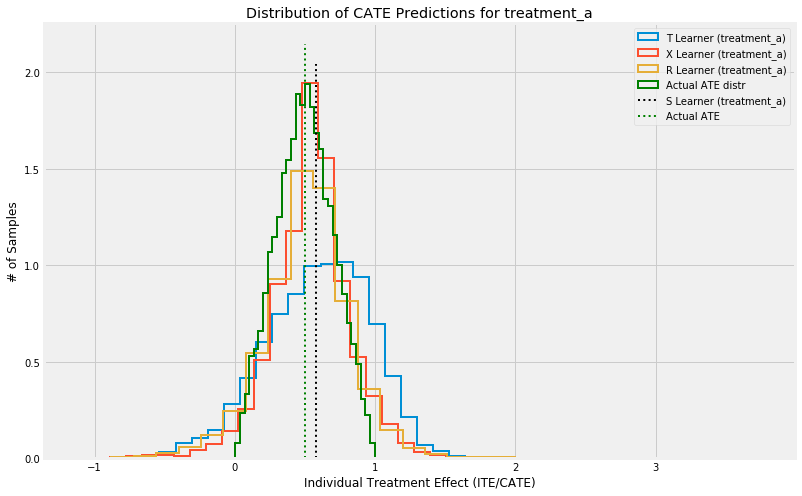

In [250]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 30
for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(cate_t[:,idx], alpha=alpha, bins=bins, label='T Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_x[:,idx], alpha=alpha, bins=bins, label='X Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_r[:,idx], alpha=alpha, bins=bins, label='R Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(tau, alpha=alpha, bins=bins, label='Actual ATE distr',
             histtype='step', linewidth=linewidth, color='green', density=True)
    plt.vlines(cate_s[0,idx], 0, plt.axes().get_ylim()[1], label='S Learner ({})'.format(group),
               linestyles='dotted', linewidth=linewidth)
    plt.vlines(tau.mean(), 0, plt.axes().get_ylim()[1], label='Actual ATE',
               linestyles='dotted', linewidth=linewidth, color='green')
    
    plt.title('Distribution of CATE Predictions for {}'.format(group))
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    _=plt.legend()

---
# Multiple Treatment Case

### Generate synthetic data
Note: we randomize the assignment of treatment flag AFTER the synthetic data generation process, so it doesn't make sense to measure accuracy metrics here. Next steps would be to include multi-treatment in the DGP itself.

In [251]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array([('treatment_a' if np.random.random() > 0.2 else 'treatment_b') 
                      if val==1 else 'control' for val in treatment])

e = {group: e for group in np.unique(treatment)}

In [252]:
pd.Series(treatment).value_counts()

control        4798
treatment_a    4131
treatment_b    1071
dtype: int64

## S-Learner

### ATE

In [253]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9474
INFO:causalml:    RMSE (Treatment):     0.9560
INFO:causalml:   sMAPE   (Control):     0.7993
INFO:causalml:   sMAPE (Treatment):     0.4612
INFO:causalml:    Gini   (Control):     0.4574
INFO:causalml:    Gini (Treatment):     0.5122
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9379
INFO:causalml:    RMSE (Treatment):     0.9648
INFO:causalml:   sMAPE   (Control):     0.7932
INFO:causalml:   sMAPE (Treatment):     0.4788
INFO:causalml:    Gini   (Control):     0.4786
INFO:causalml:    Gini (Treatment):     0.5186


In [254]:
ate_s

array([0.57222204, 0.54491608])

In [255]:
learner_s._classes

{'treatment_a': 0, 'treatment_b': 1}

### ATE w/ Confidence Intervals
Note: S-Learner is the only learner that uses bootstrapping to get confidence intervals.

In [256]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9474
INFO:causalml:    RMSE (Treatment):     0.9560
INFO:causalml:   sMAPE   (Control):     0.7993
INFO:causalml:   sMAPE (Treatment):     0.4612
INFO:causalml:    Gini   (Control):     0.4574
INFO:causalml:    Gini (Treatment):     0.5122
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9379
INFO:causalml:    RMSE (Treatment):     0.9648
INFO:causalml:   sMAPE   (Control):     0.7932
INFO:causalml:   sMAPE (Treatment):     0.4788
INFO:causalml:    Gini   (Control):     0.4786
INFO:causalml:    Gini (Treatment):     0.5186
INFO:causalml:11/100 bootstraps completed. (5s lapsed)
INFO:causalml:21/100 bootstraps completed. (10s lapsed)
INFO:causalml:31/100 bootstraps completed. (15s lapsed)
INFO:causalml:41/100 bootstraps completed. (19s lapsed)
INFO:causalml:51/100 bootstraps completed. (24s lapsed)
INFO:causalml:61/100 bootstraps completed. (29s lapsed)
I

In [257]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.28157484, 0.11983185],
       [0.57222204, 0.54491608],
       [0.84335437, 0.90839041]])

### CATE

In [258]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9474
INFO:causalml:    RMSE (Treatment):     0.9560
INFO:causalml:   sMAPE   (Control):     0.7993
INFO:causalml:   sMAPE (Treatment):     0.4612
INFO:causalml:    Gini   (Control):     0.4574
INFO:causalml:    Gini (Treatment):     0.5122
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9379
INFO:causalml:    RMSE (Treatment):     0.9648
INFO:causalml:   sMAPE   (Control):     0.7932
INFO:causalml:   sMAPE (Treatment):     0.4788
INFO:causalml:    Gini   (Control):     0.4786
INFO:causalml:    Gini (Treatment):     0.5186


In [259]:
cate_s

array([[ 0.7110523 ,  0.72896063],
       [ 0.46170068,  0.53204143],
       [ 0.67015076,  0.52216578],
       ...,
       [ 0.21919394, -0.00995845],
       [ 0.68947518,  0.5184747 ],
       [ 0.42201948,  0.1686368 ]])

### CATE w/ Confidence Intervals

In [260]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9474
INFO:causalml:    RMSE (Treatment):     0.9560
INFO:causalml:   sMAPE   (Control):     0.7993
INFO:causalml:   sMAPE (Treatment):     0.4612
INFO:causalml:    Gini   (Control):     0.4574
INFO:causalml:    Gini (Treatment):     0.5122
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9379
INFO:causalml:    RMSE (Treatment):     0.9648
INFO:causalml:   sMAPE   (Control):     0.7932
INFO:causalml:   sMAPE (Treatment):     0.4788
INFO:causalml:    Gini   (Control):     0.4786
INFO:causalml:    Gini (Treatment):     0.5186
INFO:causalml:11/100 bootstraps completed. (5s lapsed)
INFO:causalml:21/100 bootstraps completed. (10s lapsed)
INFO:causalml:31/100 bootstraps completed. (14s lapsed)
INFO:causalml:41/100 bootstraps completed. (19s lapsed)
INFO:causalml:51/100 bootstraps completed. (24s lapsed)
INFO:causalml:61/100 bootstraps completed. (29s lapsed)
I

In [261]:
cate_s

array([[ 0.7110523 ,  0.72896063],
       [ 0.46170068,  0.53204143],
       [ 0.67015076,  0.52216578],
       ...,
       [ 0.21919394, -0.00995845],
       [ 0.68947518,  0.5184747 ],
       [ 0.42201948,  0.1686368 ]])

In [262]:
cate_s_lb

array([[ 0.34773584,  0.38833598],
       [ 0.32855405,  0.25709299],
       [ 0.3835393 ,  0.24827995],
       ...,
       [-0.01215666, -0.34909957],
       [ 0.42033499,  0.18343877],
       [-0.10599099, -0.27173222]])

In [263]:
cate_s_ub

array([[0.895006  , 1.10417335],
       [0.91031416, 1.09631784],
       [0.91053412, 0.77388544],
       ...,
       [0.54893577, 0.62338302],
       [0.94226302, 0.88975289],
       [0.68634911, 0.66780635]])

## T-Learner

### ATE w/ Confidence Intervals

In [264]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9433
INFO:causalml:    RMSE (Treatment):     0.9223
INFO:causalml:   sMAPE   (Control):     0.7871
INFO:causalml:   sMAPE (Treatment):     0.4512
INFO:causalml:    Gini   (Control):     0.4659
INFO:causalml:    Gini (Treatment):     0.5554
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9766
INFO:causalml:    RMSE (Treatment):     0.8209
INFO:causalml:   sMAPE   (Control):     0.7895
INFO:causalml:   sMAPE (Treatment):     0.4336
INFO:causalml:    Gini   (Control):     0.4273
INFO:causalml:    Gini (Treatment):     0.7174


In [265]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.34933015, 0.14592573],
       [0.38843368, 0.20298838],
       [0.42753722, 0.26005102]])

### CATE

In [266]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9433
INFO:causalml:    RMSE (Treatment):     0.9223
INFO:causalml:   sMAPE   (Control):     0.7871
INFO:causalml:   sMAPE (Treatment):     0.4512
INFO:causalml:    Gini   (Control):     0.4659
INFO:causalml:    Gini (Treatment):     0.5554
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9766
INFO:causalml:    RMSE (Treatment):     0.8209
INFO:causalml:   sMAPE   (Control):     0.7895
INFO:causalml:   sMAPE (Treatment):     0.4336
INFO:causalml:    Gini   (Control):     0.4273
INFO:causalml:    Gini (Treatment):     0.7174


In [267]:
cate_t

array([[ 0.07843971,  0.62060785],
       [ 0.67675459, -0.2323246 ],
       [ 0.37720966,  0.0314579 ],
       ...,
       [-0.09979409, -0.43892848],
       [ 0.50073576,  0.2235105 ],
       [ 0.10807228,  0.63284099]])

### CATE w/ Confidence Intervals

In [268]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9433
INFO:causalml:    RMSE (Treatment):     0.9223
INFO:causalml:   sMAPE   (Control):     0.7871
INFO:causalml:   sMAPE (Treatment):     0.4512
INFO:causalml:    Gini   (Control):     0.4659
INFO:causalml:    Gini (Treatment):     0.5554
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9766
INFO:causalml:    RMSE (Treatment):     0.8209
INFO:causalml:   sMAPE   (Control):     0.7895
INFO:causalml:   sMAPE (Treatment):     0.4336
INFO:causalml:    Gini   (Control):     0.4273
INFO:causalml:    Gini (Treatment):     0.7174
INFO:causalml:10/100 bootstraps completed. (6s lapsed)
INFO:causalml:20/100 bootstraps completed. (12s lapsed)
INFO:causalml:30/100 bootstraps completed. (18s lapsed)
INFO:causalml:40/100 bootstraps completed. (24s lapsed)
INFO:causalml:50/100 bootstraps completed. (30s lapsed)
INFO:causalml:60/100 bootstraps completed. (36s lapsed)
I

In [269]:
cate_t

array([[ 0.07843971,  0.62060785],
       [ 0.67675459, -0.2323246 ],
       [ 0.37720966,  0.0314579 ],
       ...,
       [-0.09979409, -0.43892848],
       [ 0.50073576,  0.2235105 ],
       [ 0.10807228,  0.63284099]])

In [270]:
cate_t_lb

array([[-0.53212722, -0.30903141],
       [-0.11879453, -0.74498232],
       [-0.10895857, -0.67974144],
       ...,
       [-0.45499107, -0.87762732],
       [-0.00316302, -0.62013881],
       [-0.92662416, -0.79869654]])

In [271]:
cate_t_ub

array([[1.11578433, 1.30606542],
       [1.09485216, 1.18135833],
       [0.81800099, 0.54585419],
       ...,
       [0.59724846, 0.83810846],
       [0.93970177, 0.73656077],
       [0.89648482, 1.36169408]])

## X-Learner

### ATE w/ Confidence Intervals

In [272]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9276
INFO:causalml:    RMSE (Treatment):     0.9223
INFO:causalml:   sMAPE   (Control):     0.7885
INFO:causalml:   sMAPE (Treatment):     0.4512
INFO:causalml:    Gini   (Control):     0.4967
INFO:causalml:    Gini (Treatment):     0.5554
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9276
INFO:causalml:    RMSE (Treatment):     0.8209
INFO:causalml:   sMAPE   (Control):     0.7885
INFO:causalml:   sMAPE (Treatment):     0.4336
INFO:causalml:    Gini   (Control):     0.4967
INFO:causalml:    Gini (Treatment):     0.7174


In [273]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.50505838, 0.45462766],
       [0.54392714, 0.51127676],
       [0.58279589, 0.56792587]])

### CATE

In [274]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9276
INFO:causalml:    RMSE (Treatment):     0.9223
INFO:causalml:   sMAPE   (Control):     0.7885
INFO:causalml:   sMAPE (Treatment):     0.4512
INFO:causalml:    Gini   (Control):     0.4967
INFO:causalml:    Gini (Treatment):     0.5554
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9276
INFO:causalml:    RMSE (Treatment):     0.8209
INFO:causalml:   sMAPE   (Control):     0.7885
INFO:causalml:   sMAPE (Treatment):     0.4336
INFO:causalml:    Gini   (Control):     0.4967
INFO:causalml:    Gini (Treatment):     0.7174


In [275]:
cate_x

array([[ 0.51011193,  1.11665416],
       [ 0.63057578,  0.93714559],
       [ 0.56651378,  0.62864852],
       ...,
       [ 0.0706934 , -0.24768382],
       [ 0.6520552 ,  0.55430686],
       [ 0.32744938,  0.20324787]])

### CATE w/ Confidence Intervals

In [277]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9276
INFO:causalml:    RMSE (Treatment):     0.9223
INFO:causalml:   sMAPE   (Control):     0.7885
INFO:causalml:   sMAPE (Treatment):     0.4512
INFO:causalml:    Gini   (Control):     0.4967
INFO:causalml:    Gini (Treatment):     0.5554
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9276
INFO:causalml:    RMSE (Treatment):     0.8209
INFO:causalml:   sMAPE   (Control):     0.7885
INFO:causalml:   sMAPE (Treatment):     0.4336
INFO:causalml:    Gini   (Control):     0.4967
INFO:causalml:    Gini (Treatment):     0.7174
INFO:causalml:10/100 bootstraps completed. (4s lapsed)
INFO:causalml:20/100 bootstraps completed. (8s lapsed)
INFO:causalml:30/100 bootstraps completed. (11s lapsed)
INFO:causalml:40/100 bootstraps completed. (15s lapsed)
INFO:causalml:50/100 bootstraps completed. (19s lapsed)
INFO:causalml:60/100 bootstraps completed. (23s lapsed)
IN

In [278]:
learner_x._classes

{'treatment_a': 0, 'treatment_b': 1}

In [279]:
cate_x

array([[ 0.51011193,  1.11665416],
       [ 0.63057578,  0.93714559],
       [ 0.56651378,  0.62864852],
       ...,
       [ 0.0706934 , -0.24768382],
       [ 0.6520552 ,  0.55430686],
       [ 0.32744938,  0.20324787]])

In [280]:
cate_x_lb

array([[-0.12947168, -0.59684465],
       [ 0.14511852, -0.09586008],
       [-0.06014985, -0.19478888],
       ...,
       [-0.47372837, -0.77667013],
       [-0.01208761, -0.16601014],
       [-1.09851137, -1.25647704]])

In [281]:
cate_x_ub

array([[1.4489592 , 1.56688626],
       [1.64714022, 1.86003685],
       [1.25445629, 1.3876931 ],
       ...,
       [0.82276537, 1.19296496],
       [1.22051817, 1.3174639 ],
       [1.05864714, 1.66282994]])

## R-Learner

### ATE w/ Confidence Intervals

In [282]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [283]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.50585937, 0.53371618],
       [0.50626388, 0.53436845],
       [0.5066684 , 0.53502073]])

### CATE

In [284]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [285]:
cate_r

array([[ 0.47630477,  0.39759061],
       [ 0.42579198,  0.51405406],
       [ 0.67396069,  0.51410764],
       ...,
       [ 0.15357456, -0.29675448],
       [ 0.67324972,  0.79289162],
       [ 0.18124461,  0.19601935]])

### CATE w/ Confidence Intervals

In [286]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:10/100 bootstraps completed. (6s lapsed)
INFO:causalml:20/100 bootstraps completed. (11s lapsed)
INFO:causalml:30/100 bootstraps completed. (17s lapsed)
INFO:causalml:40/100 bootstraps completed. (23s lapsed)
INFO:causalml:50/100 bootstraps completed. (28s lapsed)
INFO:causalml:60/100 bootstraps completed. (34s lapsed)
INFO:causalml:70/100 bootstraps completed. (39s lapsed)
INFO:causalml:80/100 bootstraps completed. (44s lapsed)
INFO:causalml:90/100 bootstraps completed. (50s lapsed)


In [287]:
cate_r

array([[ 0.40322813,  0.54269838],
       [ 0.39800978,  0.57912332],
       [ 0.6299926 ,  0.52691686],
       ...,
       [ 0.1465683 , -0.50364113],
       [ 0.67988652,  0.78473824],
       [ 0.14495316,  0.22803634]])

In [288]:
cate_r_lb

array([[-1.00395276, -0.7525253 ],
       [-1.09133305, -0.49386598],
       [-0.40646755, -0.65167602],
       ...,
       [-0.88159316, -1.23170861],
       [-0.19269688, -0.24206508],
       [-1.24128244, -1.78349458]])

In [289]:
cate_r_ub

array([[1.81883051, 1.94110912],
       [2.13361122, 2.1823402 ],
       [1.61409808, 1.69780168],
       ...,
       [1.24102452, 1.5892303 ],
       [1.71756125, 1.57980649],
       [1.69272904, 1.63786195]])